# TP2 : Bandits

Laurent Fainsin

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
K = 10
T = 1000
EPOCHS = 5000
EPSILON = 0.15
np.random.seed(42)
PROB = np.random.rand(K)
BEST = np.argmax(PROB)
print(PROB)

[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258]


# $\epsilon$-greedy

In [3]:
def epsilon_greedy(epochs=EPOCHS, t_max=T, epsilon=EPSILON):
    A = -np.ones((epochs, t_max), dtype=np.int32)
    R = np.zeros((epochs, t_max), dtype=np.float32)

    for epoch in range(epochs):
        rewards = np.zeros(K)
        counts = np.zeros(K)
        for t in range(t_max):
            if np.random.rand() < epsilon:
                a = np.random.randint(K)
            else:
                a = np.argmax(rewards / counts)

            reward = np.random.rand() < PROB[a]
            rewards[a] += reward
            counts[a] += 1
            
            A[epoch, t] = a
            R[epoch, t] = reward
    
    return A, R

A_eps, R_eps = epsilon_greedy()

/tmp/ipykernel_2937633/564047854.py:12: RuntimeWarning: invalid value encountered in divide
  a = np.argmax(rewards / counts)


# Decaying $\epsilon$-greedy

In [4]:
def decay_epsilon_greedy(epochs=EPOCHS, t_max=T):
    A = -np.ones((epochs, t_max), dtype=np.int32)
    R = np.zeros((epochs, t_max), dtype=np.float32)

    for epoch in range(epochs):
        rewards = np.zeros(K)
        counts = np.zeros(K)
        for t in range(t_max):
            epsilon = 1.0 / (0.1 * t + 1)
            if np.random.rand() < epsilon:
                a = np.random.randint(K)
            else:
                a = np.argmax(rewards / counts)

            reward = np.random.rand() < PROB[a]
            rewards[a] += reward
            counts[a] += 1
            
            A[epoch, t] = a
            R[epoch, t] = reward
    
    return A, R

A_deps, R_deps = decay_epsilon_greedy()

/tmp/ipykernel_2937633/3008607987.py:13: RuntimeWarning: invalid value encountered in divide
  a = np.argmax(rewards / counts)


# Upper confidence interval

In [5]:
def UCB(epochs=EPOCHS, t_max=T, c=2):
    A = -np.ones((epochs, t_max), dtype=np.int32)
    R = np.zeros((epochs, t_max), dtype=np.float32)

    for epoch in range(epochs):
        rewards = np.zeros(K)
        counts = np.zeros(K)
        for t in range(t_max):
            
            epsilons = np.sqrt(c * np.log(t + 1) / (counts + 1e-5))
 
            a = np.argmax(rewards / counts + epsilons)

            reward = np.random.rand() < PROB[a]
            rewards[a] += reward
            counts[a] += 1
            
            A[epoch, t] = a
            R[epoch, t] = reward
    
    return A, R

A_ucb, R_ucb = UCB()

/tmp/ipykernel_2937633/3010206541.py:12: RuntimeWarning: invalid value encountered in divide
  a = np.argmax(rewards / counts + epsilons)


# Optimistic greedy

In [6]:
def optimistic_greedy(epochs=EPOCHS, t_max=T, Q0=100):
    A = -np.ones((epochs, t_max), dtype=np.int32)
    R = np.zeros((epochs, t_max), dtype=np.float32)

    for epoch in range(epochs):
        value = Q0 * np.ones(K)
        counts = np.zeros(K)
        for t in range(t_max):
            a = np.argmax(value)

            reward = np.random.rand() < PROB[a]
            counts[a] += 1
            value[a] += (reward - value[a]) / counts[a]
            
            A[epoch, t] = a
            R[epoch, t] = reward
    
    return A, R

A_opt, R_opt = optimistic_greedy()

# Gradient method

In [7]:
def gradient(epochs=EPOCHS, t_max=T, alpha=0.1):
    A = -np.ones((epochs, t_max), dtype=np.int32)
    R = np.zeros((epochs, t_max), dtype=np.float32)

    for epoch in range(epochs):
        H = np.zeros(K)
        rewards = np.zeros(K)
        counts = np.zeros(K)

        for t in range(t_max):
            # softmax(H) -> probs -> action
            probs = np.exp(H) / np.sum(np.exp(H))
            a = np.random.choice(K, p=probs)

            # update rewards
            reward = np.random.rand() < PROB[a]
            rewards[a] += reward
            counts[a] += 1

            # one hot vector for action
            one_hot = np.zeros(K)
            one_hot[a] = 1

            # update H
            H += alpha * (reward - rewards / (counts + 1e-5)) * (one_hot - probs)
            
            # update A and R
            A[epoch, t] = a
            R[epoch, t] = reward
    
    return A, R

A_grad, R_grad = gradient()

# Mean rewards

Mean reward Epsilon-greedy: 871.75
Mean reward Optimistic-greedy: 920.57
Mean reward Decaying Epsilon-greedy: 913.69
Mean reward UCB: 809.02
Mean reward Gradient: 807.94


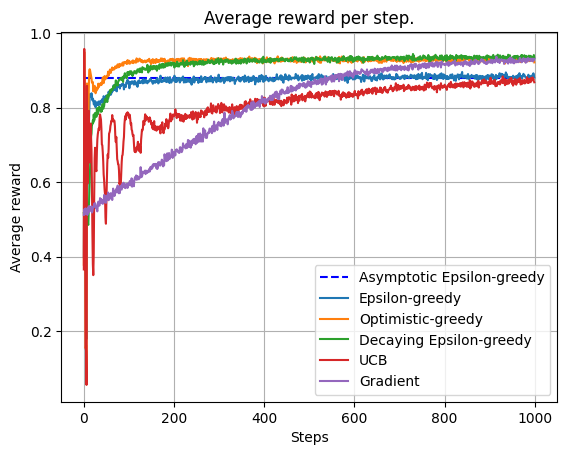

In [8]:
mean_reward_eps = np.mean(np.sum(R_eps, axis=1))
mean_reward_opt = np.mean(np.sum(R_opt, axis=1))
mean_reward_deps = np.mean(np.sum(R_deps, axis=1))
mean_reward_ucb = np.mean(np.sum(R_ucb, axis=1))
mean_reward_grad = np.mean(np.sum(R_grad, axis=1))

asymptotic_reward_eps = EPSILON * (np.sum(PROB) - np.max(PROB)) / (K - 1) + (1 - EPSILON) * np.max(PROB)

print(f"Mean reward Epsilon-greedy: {mean_reward_eps:.02f}")
print(f"Mean reward Optimistic-greedy: {mean_reward_opt:.02f}")
print(f"Mean reward Decaying Epsilon-greedy: {mean_reward_deps:.02f}")
print(f"Mean reward UCB: {mean_reward_ucb:.02f}")
print(f"Mean reward Gradient: {mean_reward_grad:.02f}")

plt.plot([0, T], [asymptotic_reward_eps]*2, 'b--', label="Asymptotic Epsilon-greedy")
plt.plot(np.mean(R_eps, axis=0), label="Epsilon-greedy")
plt.plot(np.mean(R_opt, axis=0), label="Optimistic-greedy")
plt.plot(np.mean(R_deps, axis=0), label="Decaying Epsilon-greedy")
plt.plot(np.mean(R_ucb, axis=0), label="UCB")
plt.plot(np.mean(R_grad, axis=0), label="Gradient")

plt.title("Average reward per step.")
plt.xlabel("Steps")
# plt.ylim(0.4, 0.7)
plt.ylabel("Average reward")
plt.legend()
plt.grid()
plt.show()

# Cumulative regret

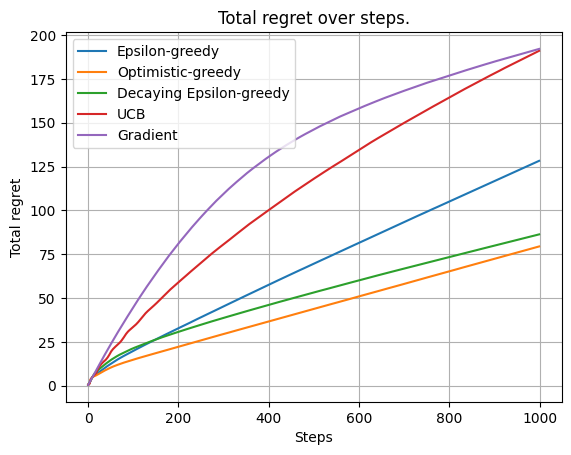

In [9]:
mean_cum_reward_eps = np.arange(1, T+1) - np.cumsum(np.mean(R_eps, axis=0))
mean_cum_reward_opt = np.arange(1, T+1) - np.cumsum(np.mean(R_opt, axis=0))
mean_cum_reward_deps = np.arange(1, T+1) - np.cumsum(np.mean(R_deps, axis=0))
mean_cum_reward_ucb = np.arange(1, T+1) - np.cumsum(np.mean(R_ucb, axis=0))
mean_cum_reward_grad = np.arange(1, T+1) - np.cumsum(np.mean(R_grad, axis=0))

plt.plot(mean_cum_reward_eps, label="Epsilon-greedy")
plt.plot(mean_cum_reward_opt, label="Optimistic-greedy")
plt.plot(mean_cum_reward_deps, label="Decaying Epsilon-greedy")
plt.plot(mean_cum_reward_ucb, label="UCB")
plt.plot(mean_cum_reward_grad, label="Gradient")

plt.xlabel("Steps")
plt.ylabel("Total regret")
plt.title("Total regret over steps.")
plt.legend()
plt.grid()
plt.show()

# Verification convergence

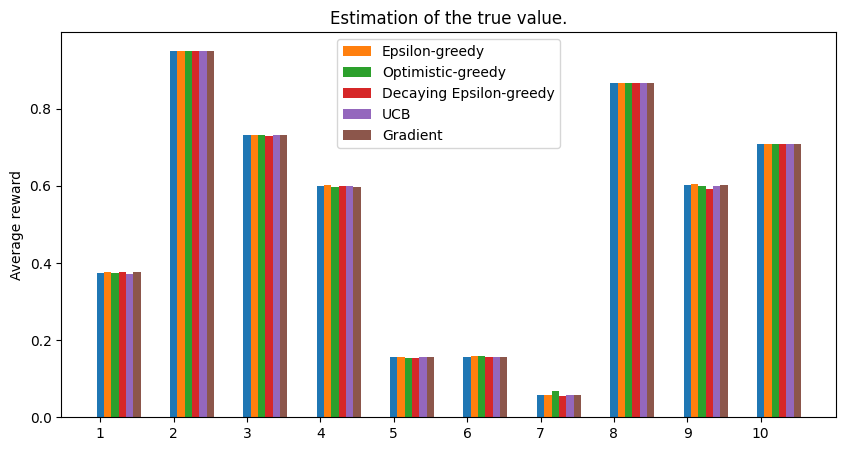

In [10]:
plt.figure(figsize=(10, 5))

plt.bar(np.arange(1, K+1)*2, PROB, 0.2)
plt.bar(np.arange(1, K+1)*2+0.2, [np.sum(R_eps[A_eps == k]) / np.sum(A_eps == k) for k in range(K)], 0.2, label="Epsilon-greedy")
plt.bar(np.arange(1, K+1)*2+0.4, [np.sum(R_opt[A_opt == k]) / np.sum(A_opt == k) for k in range(K)], 0.2, label="Optimistic-greedy")
plt.bar(np.arange(1, K+1)*2+0.6, [np.sum(R_deps[A_deps == k]) / np.sum(A_deps == k) for k in range(K)], 0.2, label="Decaying Epsilon-greedy")
plt.bar(np.arange(1, K+1)*2+0.8, [np.sum(R_ucb[A_ucb == k]) / np.sum(A_ucb == k) for k in range(K)], 0.2, label="UCB")
plt.bar(np.arange(1, K+1)*2+1.0, [np.sum(R_grad[A_grad == k]) / np.sum(A_grad == k) for k in range(K)], 0.2, label="Gradient")

plt.xticks(np.arange(1, K+1)*2, np.arange(1, K+1))
plt.title('Estimation of the true value.')
plt.ylabel('Average reward')
plt.legend()
plt.show()

# Best arm selection

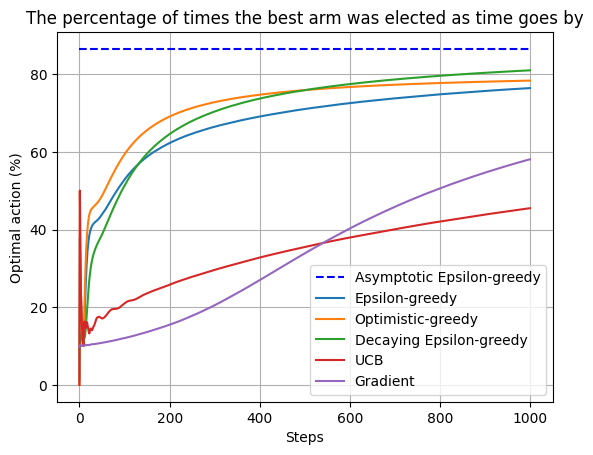

In [11]:
selected_best_cum_eps = np.mean(np.cumsum(A_eps == BEST, axis=1), axis=0) / np.arange(1, T+1)
selected_best_cum_opt = np.mean(np.cumsum(A_opt == BEST, axis=1), axis=0) / np.arange(1, T+1)
selected_best_cum_deps = np.mean(np.cumsum(A_deps == BEST, axis=1), axis=0) / np.arange(1, T+1)
selected_best_cum_ucb = np.mean(np.cumsum(A_ucb == BEST, axis=1), axis=0) / np.arange(1, T+1)
selected_best_cum_grad = np.mean(np.cumsum(A_grad == BEST, axis=1), axis=0) / np.arange(1, T+1)

asymptote = (1 - EPSILON) + EPSILON * 1/K

plt.plot([0, T], [100*asymptote]*2, 'b--', label="Asymptotic Epsilon-greedy")
plt.plot(100*selected_best_cum_eps, label="Epsilon-greedy")
plt.plot(100*selected_best_cum_opt, label="Optimistic-greedy")
plt.plot(100*selected_best_cum_deps, label="Decaying Epsilon-greedy")
plt.plot(100*selected_best_cum_ucb, label="UCB")
plt.plot(100*selected_best_cum_grad, label="Gradient")

plt.title("The percentage of times the best arm was elected as time goes by")
plt.xlabel("Steps")
plt.ylabel("Optimal action (%)")
plt.legend()
plt.grid()
plt.show()

# MeanReward($\epsilon$)

/tmp/ipykernel_2937633/564047854.py:12: RuntimeWarning: invalid value encountered in divide
  a = np.argmax(rewards / counts)


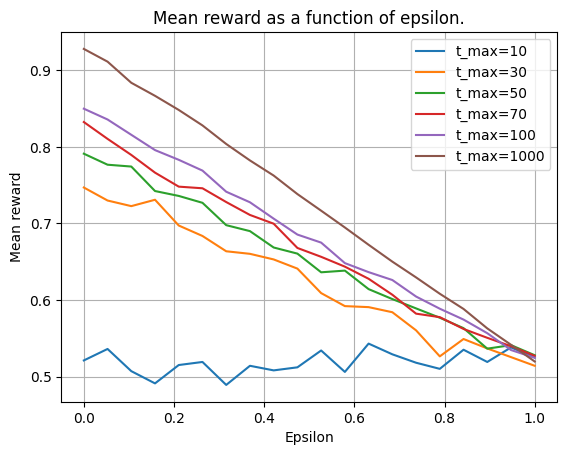

In [12]:
epsilons = np.linspace(0.0, 1.0, 20)
for t_max in [10, 30, 50, 70, 100, 1000]:
    mean_rewards = []
    for epsilon in epsilons:
        A, R = epsilon_greedy(epochs=100, t_max=t_max, epsilon=epsilon)
        mean_rewards.append(np.mean(np.sum(R, axis=1)) / t_max)
    plt.plot(epsilons, mean_rewards, label=f"t_max={t_max}")
plt.legend()
plt.title("Mean reward as a function of epsilon.")
plt.xlabel("Epsilon")
plt.ylabel("Mean reward")
plt.grid()
plt.show()

# Questions

2. With ε-greedy, what is the asymptotic probability of taking the optimal action?

Si on imagine que l'on a la appris la politique optimal, alors il vient simplement que la probabilité de choisir le bon bandit est:

$\displaystyle(1 - \epsilon) + \epsilon * \frac1K$

3. Which ε is better for a relatively small of T ? and for large T

Une valeur relativement faible de ε est meilleure pour une valeur relativement faible de T, car elle permet à l'algorithme d'explorer et d'apprendre davantage sur les bras en un temps plus court. Une valeur plus grande de ε est meilleure pour une grande valeur de T, car elle permet à l'algorithme de continuer à explorer et à apprendre sur les bras sur une plus longue période de temps.

4. Do you observe some spikes in the plot of average rewards? if yes, please provide an explanation.

On observer des instabilité lors des premières steps, cela est très probablement dû au fait que l'on divise par des nombres très petits au lorsque l'on a pas encore exploré toutes les machines. On observe aussi des pics lorsque l'algorithme explore un bras avec une faible valeur attendue et reçoit une récompense élevée, ce qui provoque un pic temporaire dans la récompense moyenne.

6. What are your conclusions in terms of methods? Give some intuition.

La méthode ε-greedy est une méthode simple et largement utilisée pour équilibrer l'exploration et l'exploitation dans l'apprentissage par renforcement. Sa version améliorée decaying epsilon greedy permet toute fois d'obtenir de meilleurs performances.

# Parameter study by Learning curve

In [ ]:
parameters = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]

epsilon_greedy_rewards = []
gradient_rewards = []
ucb_rewards = []
optimistic_greedy_rewards = []

for p in parameters:

    A, R = epsilon_greedy(epsilon=p)
    epsilon_greedy_rewards.append(np.mean(np.sum(R, axis=1)))

    A, R = gradient(alpha=p)
    gradient_rewards.append(np.mean(np.sum(R, axis=1)))

    A, R = UCB(c=p)
    ucb_rewards.append(np.mean(np.sum(R, axis=1)))

    A, R = optimistic_greedy(Q0=p)
    optimistic_greedy_rewards.append(np.mean(np.sum(R, axis=1)))


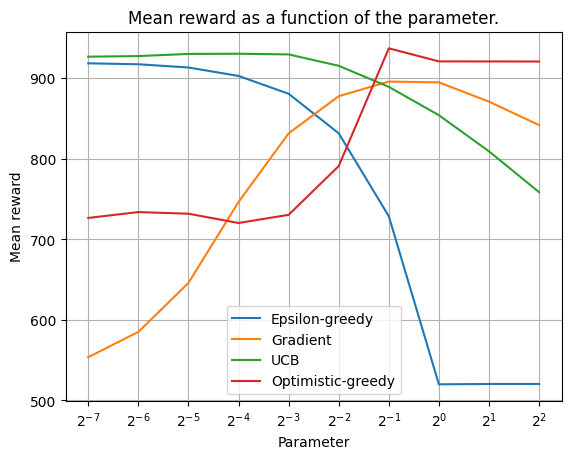

In [31]:
plt.plot(epsilon_greedy_rewards, label="Epsilon-greedy")
plt.plot(gradient_rewards, label="Gradient")
plt.plot(ucb_rewards, label="UCB")
plt.plot(optimistic_greedy_rewards, label="Optimistic-greedy")
plt.title("Mean reward as a function of the parameter.")
plt.xlabel("Parameter")
plt.ylabel("Mean reward")
plt.xticks(range(10), [rf"$2^{{ {i} }}$" for i in range(-7, 3)])
plt.legend()
plt.grid()


1. What is the best algorithm for this example ?

UCB

2. Can you comment on the shape of the curves ? what is the optimal parameter in each of the algorithms ?



In [33]:
print("Best parameter for epsilon-greedy:", parameters[np.argmax(epsilon_greedy_rewards)])
print("Best parameter for gradient:", parameters[np.argmax(gradient_rewards)])
print("Best parameter for UCB:", parameters[np.argmax(ucb_rewards)])
print("Best parameter for optimistic-greedy:", parameters[np.argmax(optimistic_greedy_rewards)])

Best parameter for epsilon-greedy: 0.0078125
Best parameter for gradient: 0.5
Best parameter for UCB: 0.0625
Best parameter for optimistic-greedy: 0.5
